<a href="https://colab.research.google.com/github/polrgn/biomedical_clustering_topic_modeling/blob/main/1_EDA_data_cleaning_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load libraries

In [ ]:
import numpy as np 
import pandas as pd
import random
import seaborn as sns

import pickle
import glob
import os
import json
import joblib
from time import time

from tqdm import tqdm
import matplotlib.pyplot as plt

import spacy
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud
from gensim.models.keyedvectors import KeyedVectors

Mounting Google drive

In [ ]:
# Mounting Google drive where we save our data and embeddings
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Data loading

We read the metadata containing the abstracts.

In [ ]:
root_path = 'drive/MyDrive/Projet MedML/Data/'
metadata_path = f'{root_path}metadata.csv'
meta_df = pd.read_csv(metadata_path, dtype={
    'pubmed_id': str,
    'Microsoft Academic Paper ID': str, 
    'doi': str
})
meta_df.head(2)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,5,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN


We check the shape of the array.

In [ ]:
meta_df.shape

(482221, 19)

# Exploration of the data before cleaning

We check for duplicates in the dataset.

In [ ]:
meta_df.nunique()

cord_uid            457294
sha                 160647
source_x                40
title               390264
doi                 266295
pmcid               170722
pubmed_id           233243
license                 18
abstract            310051
publish_time          7561
authors             347890
journal              34211
mag_id                   0
who_covidence_id    197114
arxiv_id              6377
pdf_json_files      160647
pmc_json_files      129700
url                 286720
s2_id               281966
dtype: int64

Cord_uid is used as key for abstracts.

In [ ]:
abstract_df = meta_df[['cord_uid','abstract']]
abstract_df.describe(include='all')

,cord_uid,abstract
count,482221,349274
unique,457294,310051
top,kgpo6psq,An amendment to this paper has been published ...
freq,84,182


We remove duplicates.

In [ ]:
abstract_df = abstract_df[abstract_df.abstract.notnull()]
abstract_df = abstract_df.drop_duplicates(['abstract'])
abstract_df.describe(include='all')

,cord_uid,abstract
count,310051,310051
unique,306993,310051
top,wtrbzn46,The outbreak of coronavirus disease 2019 (COVI...
freq,12,1


In [ ]:
counts = abstract_df['cord_uid'].value_counts()
print(counts)
counts_cord = counts.index.to_list()[1:30]
for cord in counts_cord:
  print(abstract_df[abstract_df['cord_uid']==cord]['abstract'])
  print('\n')

wtrbzn46    12
9k9qx92b     9
m1tx74tc     8
41lri82r     7
thip4xrp     5
            ..
wahn5bsz     1
3289i4lo     1
99jlejuv     1
caowtw1o     1
adgqicye     1
Name: cord_uid, Length: 306993, dtype: int64
146870    [ ]Cristian Băhnăreanu, PhD Senior Researcher,...
166470    A few years ago, when I wrote an editorial not...
220395    Professor Ofra Bengio of Tel Aviv University a...
248649    Pointing to Schuyler's and Baker's deliberate ...
259560    現在，COVID-19禍の真っただ中で本稿を執筆している．感染症は，このように全てを吹き飛ば...
278723    For US Latinas/os, those two events held speci...
298833    An introduction to the journal is presented in...
300672    In the rubric Security and Military Strategy y...
315242    Reading mechanisms of negotiation, survival, a...
Name: abstract, dtype: object


143219    First and the foremost, universities and busin...
156818    [ ]my thoughts were cemented in the beginning ...
164658    Social transformation and vulnerable populatio...
240185    [ ]through their quantitativ

In [ ]:
abstract_df = abstract_df.drop_duplicates(['cord_uid'])
abstract_df.describe(include='all')

,cord_uid,abstract
count,306993,306993
unique,306993,306993
top,kwz0b81g,The outbreak of coronavirus disease 2019 (COVI...
freq,1,1


Shuffle and sample the abstracts.

In [ ]:
from sklearn.utils import shuffle
abstract_df = shuffle(abstract_df, random_state=100).iloc[1:50000]
abstract_df.to_csv('drive/MyDrive/Projet MedML/Outputs/abstract_df_beforecleaning.csv')

Plot the most frequent tokens.

100%|██████████| 49999/49999 [00:07<00:00, 6582.59it/s]


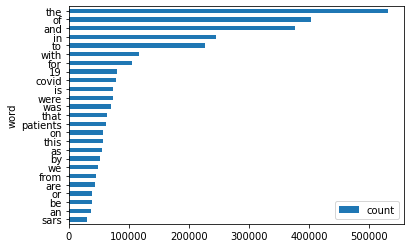

In [ ]:
abstract_df = pd.read_csv('drive/MyDrive/Projet MedML/Outputs/abstract_df_beforecleaning.csv',index_col=0)
countvectorizer = CountVectorizer()
data_vectorized = countvectorizer.fit_transform(tqdm(abstract_df.abstract))
word_count = pd.DataFrame({'word': countvectorizer.get_feature_names(), 'count': np.asarray(data_vectorized.sum(axis=0))[0]})
word_count = word_count.sort_values('count', ascending=False).set_index('word')[:25].sort_values('count', ascending=True).plot(kind='barh')
word_count.get_figure().savefig("drive/MyDrive/Projet MedML/Images/word_hist_beforecleaning.png")

Plot the most frequent non stop words

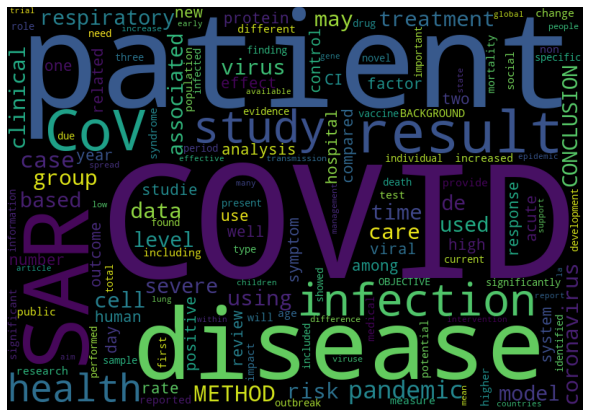

In [ ]:
bag_of_doc = ' '.join(abstract_df.abstract)
wordcloud = WordCloud(width=800, height=560,
                          background_color='black', collocations=False,
                          min_font_size=10).generate(bag_of_doc)

# plot the WordCloud image
plt.figure(figsize=(8, 5.6), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig("drive/MyDrive/Projet MedML/Images/word_cloud_beforecleaning.png")
# dr = '/kaggle/working/{}/{}'.format(model.method, model.id)
# if not os.path.exists(dr):
#     os.makedirs(dr)
# plt.savefig('/kaggle/working' + '/Topic' + str(topic) + '_wordcloud')
# print('Getting wordcloud for topic {}. Done!'.format(topic))

Size of the vocabulary

In [ ]:
vectorizer = CountVectorizer()
vectorizer.fit(abstract_df['abstract'])
print('Size of vocabulary:',len(vectorizer.vocabulary_))

Size of vocabulary: 138606


Abstract length distribution

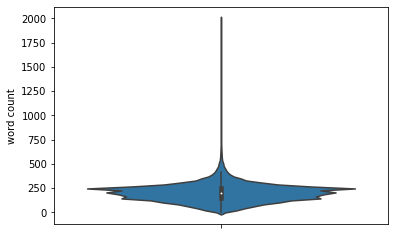

In [ ]:
abstract_df['word_count'] = abstract_df['abstract'].apply(lambda x: len(x.strip().split()))
sns_plot = sns.violinplot(y=abstract_df['word_count'])
sns_plot.set(ylabel='word count')
sns_plot.get_figure().savefig("drive/MyDrive/Projet MedML/Images/violin_plot_word_counts_init.png")

# Data cleaning and pre-processing

Load Spacy language model for pre-processing our corpus. 

Remove spacy english stopword, punctuation and number like tokens.

In [ ]:
model_name = "en_core_web_sm" # "es_core_news_md" #'en_core_sci_sm' 
spacy.cli.download(model_name)
nlp = spacy.load(model_name,disable=["tagger", "ner"])

docs = list(nlp.pipe(abstract_df.abstract))
abstract_df.abstract = [' '.join([w.text for w in doc if (not w.is_stop and not w.is_punct and not w.like_num)]) for doc in tqdm(docs)]

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


100%|██████████| 49999/49999 [00:09<00:00, 5234.53it/s]


We remove stopwords specific to the corpus: most frequent words, scientific measure units, using NLTK parser.

In [ ]:
import nltk
from nltk.tokenize import word_tokenize 
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
abstract_df_ = abstract_df 
list_stop_words = list(np.load('drive/MyDrive/Projet MedML/Data/list_stopwords.npz')['arr_0'])+['covid-19','covid','19','cov','cov2','cov-2','sars','ml','SARS','SARS-CoV-2','METHODS','BACKGROUND','OBJECTIVE']
list_stop_words = [x.lower() for x in list_stop_words]
for i in range(0,len(abstract_df)) :
  doc = abstract_df.abstract.iloc[i].lower()
  doc_tokenized = word_tokenize(doc)  
  filtered_doc = ' '.join([w for w in doc_tokenized if not w in list_stop_words])  
  abstract_df_.abstract.iloc[i] = filtered_doc

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
list_stop_words_df = pd.DataFrame({'stop_words' : list_stop_words})
list_stop_words_df.to_csv('drive/MyDrive/Projet MedML/Data/list_stopwords.csv')

In [ ]:
abstract_df_.to_csv('drive/MyDrive/Projet MedML/Outputs/abstract_df_clean_stopwords.csv')

In [ ]:
abstract_df = pd.read_csv('drive/MyDrive/Projet MedML/Outputs/abstract_df_clean_stopwords.csv',index_col=0)

We use the language detector in spacy language model to remove abstracts that are not in english (language dectector not available in Scispacy language model) 

In [ ]:
!pip install spacy-langdetect
from spacy_langdetect import LanguageDetector
nlp.add_pipe(LanguageDetector(), name='language_detector', last=True)
text_language = abstract_df['abstract'].apply(lambda x: nlp(str(x))._.language['language'])

text_language.value_counts()
abstract_df = abstract_df.drop(abstract_df[text_language != 'en'].index)
abstract_df.shape
abstract_df.to_csv('drive/MyDrive/Projet MedML/Outputs/abstract_df_clean_stopwords_lang.csv')

Number of abstracts by language detected.

In [ ]:
text_language.value_counts()

en       48748
es         390
fr         231
pt         211
de         152
nl          56
it          47
ca          43
ru          43
zh-cn       35
ko          11
hu           6
tr           5
ro           5
tl           3
et           2
af           2
da           2
vi           1
mk           1
cs           1
no           1
hr           1
fa           1
lt           1
Name: abstract, dtype: int64

Plot pf the most frequent tokens after cleaning.



100%|██████████| 48748/48748 [00:03<00:00, 12411.39it/s]


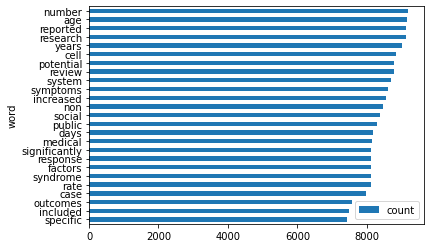

In [ ]:
abstract_df = pd.read_csv('drive/MyDrive/Projet MedML/Outputs/abstract_df_clean_stopwords_lang.csv',index_col=0)
countvectorizer = CountVectorizer()
data_vectorized = countvectorizer.fit_transform(tqdm(abstract_df.abstract))
word_count = pd.DataFrame({'word': countvectorizer.get_feature_names(), 'count': np.asarray(data_vectorized.sum(axis=0))[0]})
word_count = word_count.sort_values('count', ascending=False).set_index('word')[:25].sort_values('count', ascending=True).plot(kind='barh')
word_count.get_figure().savefig("drive/MyDrive/Projet MedML/Images/word_hist_aftercleaning.png")

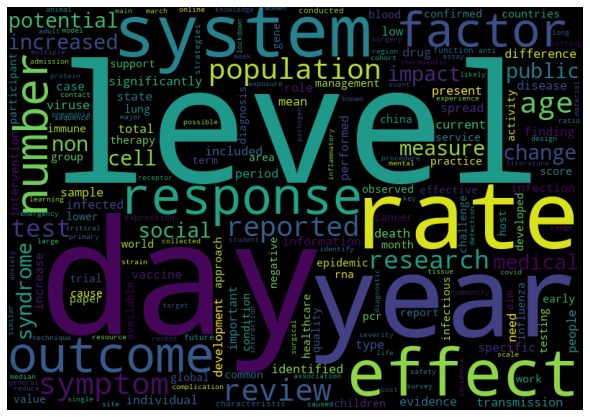

In [ ]:
bag_of_doc = ' '.join(abstract_df.abstract)
wordcloud = WordCloud(width=800, height=560,
                          background_color='black', collocations=False,
                          min_font_size=10).generate(bag_of_doc)

# plot the WordCloud image
plt.figure(figsize=(8, 5.6), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig("drive/MyDrive/Projet MedML/Images/word_cloud_aftercleaning.png")
# dr = '/kaggle/working/{}/{}'.format(model.method, model.id)
# if not os.path.exists(dr):
#     os.makedirs(dr)
# plt.savefig('/kaggle/working' + '/Topic' + str(topic) + '_wordcloud')
# print('Getting wordcloud for topic {}. Done!'.format(topic))

Size of the vocabulary

In [ ]:
vectorizer = CountVectorizer()
vectorizer.fit(abstract_df['abstract'])
print('Size of vocabulary:',len(vectorizer.vocabulary_))

Size of vocabulary: 102327


We check the word count of abstacts and see we have extremely long or extremely short abstracts. Long texts are much more difficult to process, very short texts are uninformative, we remove them.

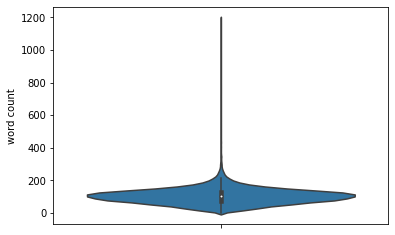

In [ ]:
abstract_df['word_count'] = abstract_df['abstract'].apply(lambda x: len(x.strip().split()))
sns_plot = sns.violinplot(y=abstract_df['word_count'])
sns_plot.set(ylabel='word count')
sns_plot

We filter out abstracts with word length, smaller than 1% percentile or larger than 99% percentile

In [ ]:
print(np.quantile(abstract_df['word_count'],0.99))
print(np.quantile(abstract_df['word_count'],0.01))
abstract_df = abstract_df[((abstract_df['word_count']>=12) & (abstract_df['word_count']<=231))]
abstract_df.to_csv('drive/MyDrive/Projet MedML/Outputs/abstract_df_clean_stopwords_lang_abstrlen.csv')

237.0
12.0


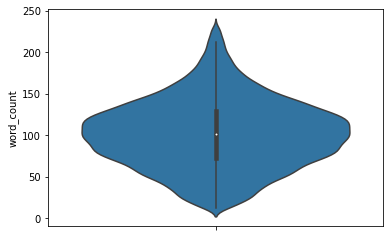

In [ ]:
abstract_df = pd.read_csv('drive/MyDrive/Projet MedML/Outputs/abstract_df_clean_stopwords_lang_abstrlen.csv',index_col=0)
sns_plot2 = sns.violinplot(y=abstract_df['word_count'])
sns_plot2.get_figure().savefig("drive/MyDrive/Projet MedML/Images/violin_plot_word_counts_cleaned.png")